In [38]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy import interpolate
from astropy.io import ascii as asciitable
from astropy.table import Table

from PRFMData import PRFMDataset
import astro_helper as ah
import density_contours

import pickle
from pathlib import Path
import glob, os, re, sys
import configparser
config = configparser.ConfigParser()
config.read('config_pressures-SFRs.ini')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from matplotlib import rc
from matplotlib.ticker import LogLocator
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
rc('axes', linewidth=1.5)
rc('axes', edgecolor='#3C3C3C')
plt.style.use('mpl_style_Jeffreson.mplstyle')

In [39]:
labels = [r"$\mathbf{M_*=10^{10}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{10.5}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{11}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{11.5}{\rm M}_\odot}$",
          r"Milky Way-like",
          r"NGC~300-like",]
colors = [plt.cm.magma((i+1)/5) for i in range(4)]
colors.append('#3C3C3C')
colors.append('#5E9F87')

In [4]:
tags = ['ETG-vlM', 'ETG-lowM', 'ETG-medM', 'ETG-hiM', 'MW', 'NGC300']
Rmaxs_kpc = [config[tag].getfloat('RMAX') for tag in tags]
Rmaxs_kpc = [1.5 if elem==2. else elem for elem in Rmaxs_kpc] # cut to actual max size of ETGs

# simulation data

In [69]:
Rbin_centers, data_densities, data_PSFRs = [], [], []
for tag in tags:
    filesavedir = Path(config[tag]['ROOT_DIR']) / config[tag]['SUBDIR']

    # weight from this array (temperature threshold here has no impact)
    filesavename = min(glob.glob(str(filesavedir / "Figs-10-11_*_T2.0e+04_avir2.0e+00.pkl")))
    with open(filesavename, "rb") as f:
        props_3D = pickle.load(f)
    data_densities.append(props_3D)

    # pressures, counts and SFRs from this array (respond to temperature threshold)
    filesavename = min(glob.glob(str(filesavedir / "pressures-SFRs-fixed-mp_*_T2.0e+04_avir2.0e+00.pkl")))
    with open(filesavename, "rb") as f:
        props_3D = pickle.load(f)
    data_PSFRs.append(props_3D)
    
    # radial bin data from this array
    filesavename = min(glob.glob(str(filesavedir / "Rbin_centers_*.pkl")))
    with open(filesavename, "rb") as f:
        Rbins = pickle.load(f)
    Rbin_centers.append(Rbins)

In [70]:
# calculate medians and quantiles
THRESHOLD = 100 # on the number of gas cells per voxel at the mid-plane
# this is particularly important for the SigmaSFR, because SFR is stochastic in this simulation, and
# values do not make sense if averages/medians are taken over too few cells

meddata, q1data, q4data = [], [], []
meddata_PSFRs, q1data_PSFRs, q4data_PSFRs = [], [], []
for i, Rmax_kpc, data_, data_PSFRs_ in zip(range(len(data_densities)), Rmaxs_kpc, data_densities, data_PSFRs):

    # take cuts to deal with stochasticity of the SFR, and to ensure the mid-plane
    # turbulent velocity dispersion is well-resolved
    cnd = (data_PSFRs_['midplane-count'] > THRESHOLD)
    for key, value in data_PSFRs_.items():
        value[~cnd] = np.nan
    for key, value in data_.items():
        if key == 'Kappa':
            continue
        value[~cnd] = np.nan

    # apply radial cut to disk extent for the ETGs
    cnd = (Rbin_centers[i]/ah.kpc_to_cm < Rmax_kpc)
    Rbin_centers[i] = Rbin_centers[i][cnd]
    meddata.append({key: np.nanmedian(value, axis=(1,2))[cnd] if key != 'Kappa' else np.nanmedian(value, axis=1) for key, value in data_.items()})
    q1data.append({key: np.nanquantile(value, 0.25, axis=(1,2))[cnd] if key != 'Kappa' else np.nanquantile(value, 0.25, axis=1) for key, value in data_.items()})
    q4data.append({key: np.nanquantile(value, 0.75, axis=(1,2))[cnd] if key != 'Kappa' else np.nanquantile(value, 0.75, axis=1) for key, value in data_.items()})

    meddata_PSFRs.append({key: np.nanmedian(value, axis=(1,2))[cnd] for key, value in data_PSFRs_.items()})
    q1data_PSFRs.append({key: np.nanquantile(value, 0.25, axis=(1,2))[cnd] for key, value in data_PSFRs_.items()})
    q4data_PSFRs.append({key: np.nanquantile(value, 0.75, axis=(1,2))[cnd] for key, value in data_PSFRs_.items()})

# observations from PHANGS and Bigiel+ 08, plus predictions from TIGRESS, SH03

In [71]:
# PHANGS data
J23 = Table.read("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/Sun+23.txt",
                   format="ascii")#, names=["Galaxy", "RA", "DEC", "SBF", "NED-D","Virgo", "VHel", "D", "M_K", "A_B", "T-type", "log(Re)"])
print(J23.keys())
PDE_J23 = J23['P-DE-S20']
ePDE_J23 = J23['e_P-DE-S20']
Sigmamol_J23 = J23['Sigma-mol-S20']
Sigmamol_J23 = J23['e_Sigma-mol-S20']
SFR_J23 = J23['Sigma-SFR-HaW4recal']
eSFR_J23 = J23['e_Sigma-SFR-HaW4recal']

['Name', 'RAdeg', 'DEdeg', 'Sigma-SFR-HaW4recal', 'e_Sigma-SFR-HaW4recal', 'Sigma-SFR-FUVW4recal', 'e_Sigma-SFR-FUVW4recal', 'Sigma-SFR-Hacorr', 'e_Sigma-SFR-Hacorr', 'Sigma-mol-S20', 'e_Sigma-mol-S20', 'Sigma-mol-MW', 'e_Sigma-mol-MW', 'Sigma-mol-B13', 'e_Sigma-mol-B13', 'Sigma-mol-G20', 'e_Sigma-mol-G20', 'Sigma-mol-per-t-orb-S20', 'e_Sigma-mol-per-t-orb-S20', 'Sigma-mol-per-t-orb-MW', 'e_Sigma-mol-per-t-orb-MW', 'Sigma-mol-per-t-orb-B13', 'e_Sigma-mol-per-t-orb-B13', 'Sigma-mol-per-t-orb-G20', 'e_Sigma-mol-per-t-orb-G20', 'Sigma-mol-per-t-ff-S20', 'e_Sigma-mol-per-t-ff-S20', 'Sigma-mol-per-t-ff-MW', 'e_Sigma-mol-per-t-ff-MW', 'Sigma-mol-per-t-ff-B13', 'e_Sigma-mol-per-t-ff-B13', 'Sigma-mol-per-t-ff-G20', 'e_Sigma-mol-per-t-ff-G20', 'P-DE-S20', 'e_P-DE-S20', 'P-DE-MW', 'e_P-DE-MW', 'P-DE-B13', 'e_P-DE-B13', 'P-DE-G20', 'e_P-DE-G20']


In [72]:
# bigiel data
xlim = [-1., 3.5]
ylim = [-4.3, -0.5]

# plot specs
n = 1000
nbin = 30
xgrd = np.linspace(xlim[0], xlim[1], nbin)
ygrd = np.linspace(ylim[0], ylim[1], nbin)
xx, yy = np.meshgrid(xgrd, ygrd)

# obs data
data_bigiel = asciitable.read('/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/bigiel.txt', Reader=asciitable.Cds)
Sigma_S1_Bigiel = np.array(data_bigiel["logSFR"])
Sigma_S2_Bigiel = np.array(data_bigiel["logSFR"])
Sigma_S3_Bigiel = np.array(data_bigiel["logSFR"])
Sigma_H2_Bigiel = np.array(data_bigiel["logH2"])
Sigma_HI_Bigiel = np.array(data_bigiel["logHI"])
Sigma_HIH2_Bigiel = np.log10(10**Sigma_H2_Bigiel + 10**Sigma_HI_Bigiel)
cnd = ((Sigma_HIH2_Bigiel != 0.0) & (np.array(data_bigiel["logSFR"]) != 0.0))
Sigma_S2_Bigiel = Sigma_S2_Bigiel[cnd]
Sigma_HIH2_Bigiel = Sigma_HIH2_Bigiel[cnd]

xHIH2 = Sigma_HIH2_Bigiel[(Sigma_HIH2_Bigiel > xlim[0]) & (Sigma_S2_Bigiel > ylim[0])]
yHIH2 = Sigma_S2_Bigiel[(Sigma_HIH2_Bigiel > xlim[0]) & (Sigma_S2_Bigiel > ylim[0])]
xyHIH2 = np.array([xHIH2, yHIH2])
kdeHIH2 = gaussian_kde(xyHIH2)
denHIH2 = kdeHIH2(np.array([xx.ravel(), yy.ravel()])).reshape(xx.shape)
denHIH2_normalized = denHIH2 / denHIH2.sum()
tHIH2 = np.linspace(0, denHIH2_normalized.max(), n)
integralHIH2 = ((denHIH2_normalized >= tHIH2[:, None, None]) * denHIH2_normalized).sum(axis=(1,2))

fHIH2 = interpolate.interp1d(integralHIH2, tHIH2)

In [73]:
# line from TIGRESS
xU = 10.**np.linspace(2.8, 7., 30)
xU_cgs = xU*ah.kB_cgs
yU_cgs = xU_cgs/(100.*ah.kms_to_cms)
yU_100 = yU_cgs/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s
yU_cgs = xU_cgs/(1000.*ah.kms_to_cms)
yU_1000 = yU_cgs/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s
yU_cgs = xU_cgs/(10000.*ah.kms_to_cms)
yU_10000 = yU_cgs/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s

UpsilonUT_cgs = 1.e5*(xU_cgs/ah.kB_cgs)**(-0.235)*10.**4.2
yUT = 10.**(1.235*np.log10(xU_cgs/ah.kB_cgs)-7.86)

In [74]:
# prediction from SH03
logsurfdenses_SH03_bincentres = np.load(
    "/n/holystore01/LABS/itc_lab/Users/sjeffreson/LtU-arrays/logsurfdenses_SH03_bincentres.npy")
med_logSigmaSFR_SH03 = np.load("/n/holystore01/LABS/itc_lab/Users/sjeffreson/LtU-arrays/med_logSigmaSFR_SH03.npy")
q1_logSigmaSFR_SH03 = np.load("/n/holystore01/LABS/itc_lab/Users/sjeffreson/LtU-arrays/q1_logSigmaSFR_SH03.npy")
q4_logSigmaSFR_SH03 = np.load("/n/holystore01/LABS/itc_lab/Users/sjeffreson/LtU-arrays/q4_logSigmaSFR_SH03.npy")

# figure

/tmp/ipykernel_152180/3705882389.py:32: RuntimeWarning: divide by zero encountered in log10
  ax0.scatter(np.log10(meddata[i]['SigmaGas']), np.log10(meddata_PSFRs[i]['SigmaSFR']), s=50, color=color, zorder=3)
/tmp/ipykernel_152180/3705882389.py:33: RuntimeWarning: divide by zero encountered in log10
  ax0.scatter(np.log10(meddata[i]['SigmaGas']), np.log10(meddata_PSFRs[i]['SigmaSFR']), s=100, color='white', zorder=2)
/tmp/ipykernel_152180/3705882389.py:46: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(meddata[i]['SigmaH2Gas']), np.log10(meddata_PSFRs[i]['SigmaSFR']), s=50, color=color, zorder=3)
/tmp/ipykernel_152180/3705882389.py:47: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(meddata[i]['SigmaH2Gas']), np.log10(meddata_PSFRs[i]['SigmaSFR']), s=100, color='white', zorder=2)
/tmp/ipykernel_152180/3705882389.py:61: UserWarning: linewidths is ignored by contourf
  ax0.contourf(denHIH2_normalized, [fHIH2(0.95), 1], linewidths=2.,

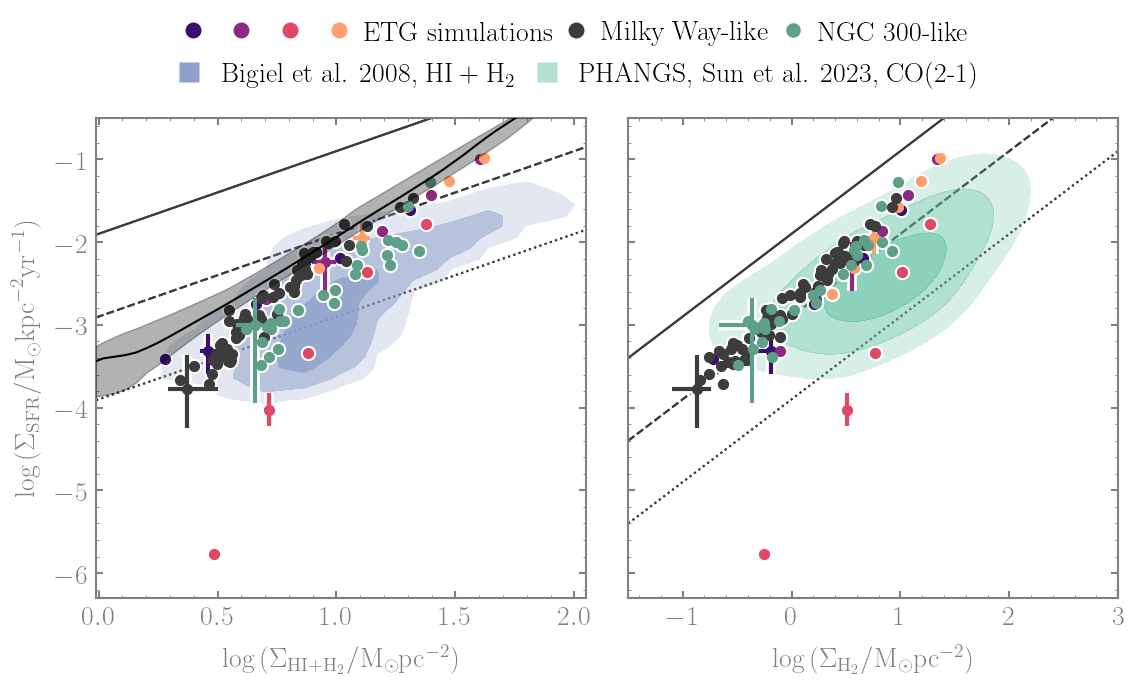

In [77]:
figW = 14
figH = 6
fig = plt.figure(figsize=(figW, figH))

topMarg = 0.1
leftMarg = 0.15
botMarg = 0.1
rightMarg = 0.15

wBetMarg = 0.03
hBetMarg = 0.01

crightMarg = 0.105
cW = 0.04
cBet = 0.02

h = (1.0-topMarg-botMarg)
w = (1.0-leftMarg-rightMarg)/2

### axes ###
ax0 = fig.add_axes([leftMarg, botMarg, w, h], ylim=[-6.3, -0.5], xlim=[-0.01, 2.05],
                  xlabel=r'$\log{(\Sigma_{\rm HI+H_2}/{\rm M}_\odot {\rm pc}^{-2})}$',
                  ylabel=r'$\log{(\Sigma_{\rm SFR}/{\rm M}_\odot {\rm kpc}^{-2}{\rm yr}^{-1})}$')
ax1 = fig.add_axes([leftMarg+w+wBetMarg, botMarg, w, h], ylim=[-6.3, -0.5], xlim=[-1.5, 2.4],
                  xlabel=r'$\log{(\Sigma_{\rm H_2}/{\rm M}_\odot {\rm pc}^{-2})}$',
                  ylabel=r'', yticklabels='')
axs = [ax0, ax1]

# plot stuff
# simulations
for color, i in zip(colors, range(len(Rbin_centers))):
    ax0.scatter(np.log10(meddata[i]['SigmaGas']), np.log10(meddata_PSFRs[i]['SigmaSFR']), s=50, color=color, zorder=3)
    ax0.scatter(np.log10(meddata[i]['SigmaGas']), np.log10(meddata_PSFRs[i]['SigmaSFR']), s=100, color='white', zorder=2)

    # one error bar
    ax0.vlines(np.log10(meddata[i]['SigmaGas'][-3]), np.log10(q1data_PSFRs[i]['SigmaSFR'][-3]),
               ymax=np.log10(q4data_PSFRs[i]['SigmaSFR'][-3]), lw=3, color=color, zorder=3)
    ax0.vlines(np.log10(meddata[i]['SigmaGas'][-3]), np.log10(q1data_PSFRs[i]['SigmaSFR'][-3]),
               ymax=np.log10(q4data_PSFRs[i]['SigmaSFR'][-3]), lw=7, color='white', zorder=2)
    ax0.hlines(np.log10(meddata_PSFRs[i]['SigmaSFR'][-3]), np.log10(q1data[i]['SigmaGas'][-3]),
               xmax=np.log10(q4data[i]['SigmaGas'][-3]), lw=3, color=color, zorder=3)
    ax0.hlines(np.log10(meddata_PSFRs[i]['SigmaSFR'][-3]), np.log10(q1data[i]['SigmaGas'][-3]),
               xmax=np.log10(q4data[i]['SigmaGas'][-3]), lw=7, color='white', zorder=2)

for color, i in zip(colors, range(len(Rbin_centers))):
    ax1.scatter(np.log10(meddata[i]['SigmaH2Gas']), np.log10(meddata_PSFRs[i]['SigmaSFR']), s=50, color=color, zorder=3)
    ax1.scatter(np.log10(meddata[i]['SigmaH2Gas']), np.log10(meddata_PSFRs[i]['SigmaSFR']), s=100, color='white', zorder=2)

    # one error bar
    ax1.vlines(np.log10(meddata[i]['SigmaH2Gas'][-3]), np.log10(q1data_PSFRs[i]['SigmaSFR'][-3]),
               ymax=np.log10(q4data_PSFRs[i]['SigmaSFR'][-3]), lw=3, color=color, zorder=3)
    ax1.vlines(np.log10(meddata[i]['SigmaH2Gas'][-3]), np.log10(q1data_PSFRs[i]['SigmaSFR'][-3]),
               ymax=np.log10(q4data_PSFRs[i]['SigmaSFR'][-3]), lw=7, color='white', zorder=2)
    ax1.hlines(np.log10(meddata_PSFRs[i]['SigmaSFR'][-3]), np.log10(q1data[i]['SigmaH2Gas'][-3]),
               xmax=np.log10(q4data[i]['SigmaH2Gas'][-3]), lw=3, color=color, zorder=3)
    ax1.hlines(np.log10(meddata_PSFRs[i]['SigmaSFR'][-3]), np.log10(q1data[i]['SigmaH2Gas'][-3]),
               xmax=np.log10(q4data[i]['SigmaH2Gas'][-3]), lw=7, color='white', zorder=2)

# observations
# Bigiel08 data
ax0.contourf(denHIH2_normalized, [fHIH2(0.95), 1], linewidths=2., colors=[plt.cm.Set2(2)], linestyles='dotted',
                   extent=[xlim[0], xlim[1], ylim[0], ylim[1]], alpha=0.25)
ax0.contourf(denHIH2_normalized, [fHIH2(0.8), 1], linewidths=2., colors=[plt.cm.Set2(2)], linestyles='dashed',
                    extent=[xlim[0], xlim[1], ylim[0], ylim[1]], alpha=0.5)
ax0.contourf(denHIH2_normalized, [fHIH2(0.4), 1], linewidths=2., colors=[plt.cm.Set2(2)], linestyles='solid',
                    extent=[xlim[0], xlim[1], ylim[0], ylim[1]], alpha=0.75)

# PHANGS
density_contours.density_contour(np.log10(J23['Sigma-mol-S20']), np.log10(J23['Sigma-SFR-HaW4recal']),
                                 xscale='linear', yscale='linear', ax=ax1, color=plt.cm.Set2(0),
                                 edgecolor='None',
                                 levels=(0.4, 0.8, 0.95), xlim=[-1.5, 3.], ylim=[-6.3, -0.5])

# lines of const. depl. time
xmin, xmax = -0.01, 3.5
x_plt = np.linspace(xmin, xmax, 100)
y_1e8 = x_plt-1.9
y_1e9 = x_plt-2.9
y_1e10 = x_plt-3.9

ax0.plot(x_plt, y_1e8, "-", color='#3C3C3C', zorder=0)
ax0.plot(x_plt, y_1e9, "--", color='#3C3C3C', zorder=0)
ax0.plot(x_plt, y_1e10, ":", color='#3C3C3C', zorder=0)
ax0.plot(x_plt, y_1e8, "-", label="$10^8$ yr", color='#3C3C3C', zorder=0)
ax0.plot(x_plt, y_1e9, "--", label="$10^9$ yr", color='#3C3C3C', zorder=0)
ax0.plot(x_plt, y_1e10, ":", label="$10^{10}$ yr", color='#3C3C3C', zorder=0)

# Line from SH03 (sample of 21 normal spirals from K98)
ax0.plot(logsurfdenses_SH03_bincentres, med_logSigmaSFR_SH03, color='k', zorder=5)
ax0.fill_between(logsurfdenses_SH03_bincentres, q1_logSigmaSFR_SH03, y2=q4_logSigmaSFR_SH03, alpha=0.3, color='k', zorder=5)

ax1.set_yticklabels('')
for ax in axs:
    ax.tick_params(axis = 'both', bottom = True, top = True, left = True, right = True,
                   which = 'both', direction='in')
    ax.minorticks_on()

# lines of const. depl. time
xmin, xmax = -1.5, 3.5
x_plt = np.linspace(xmin, xmax, 100)
y_1e8 = x_plt-1.9
y_1e9 = x_plt-2.9
y_1e10 = x_plt-3.9

ax1.plot(x_plt, y_1e8, "-", color='#3C3C3C', zorder=0)
ax1.plot(x_plt, y_1e9, "--", color='#3C3C3C', zorder=0)
ax1.plot(x_plt, y_1e10, ":", color='#3C3C3C', zorder=0)
ax1.plot(x_plt, y_1e8, "-", label="$10^8$ yr", color='#3C3C3C', zorder=0)
ax1.plot(x_plt, y_1e9, "--", label="$10^9$ yr", color='#3C3C3C', zorder=0)
ax1.plot(x_plt, y_1e10, ":", label="$10^{10}$ yr", color='#3C3C3C', zorder=0)

# legend, data
custom_lines = [Line2D([0], [0], marker='s', markeredgecolor='None', markerfacecolor=plt.cm.Set2(2),
                       markersize=15, lw=0),
                Line2D([0], [0], marker='s', markeredgecolor='None', markerfacecolor=plt.cm.Set2(0),
                       markersize=15, alpha=0.5, lw=0)]
legend1 = ax1.legend(
    custom_lines, [r'Bigiel et al. 2008, ${\rm HI+H_2}$', 'PHANGS, Sun et al. 2023, CO(2-1)'],
    loc='lower center', bbox_to_anchor=(-0.1, 1.01), ncol=2, frameon=False, handlelength=0.75, columnspacing=0.75
)

# legend, sims
custom_lines = [Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(1./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(2./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(3./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(4./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor='#3C3C3C',
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor='#5E9F87', markeredgewidth=2,
                       markeredgecolor='white', markersize=12.5, lw=3)]
legend2 = ax1.legend(
    custom_lines, [r'', r'', r'', r'ETG simulations', r'Milky Way-like', r'NGC~300-like'],
    loc='lower center', bbox_to_anchor=(-0.1, 1.1), ncol=6, frameon=False, handlelength=0.2, columnspacing=0.75
)
ax1.add_artist(legend1)
#ax1.add_artist(legend2)

# plt.savefig(
#     '/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/figs/obs-comparison-Sigmagas.pdf',
#     bbox_inches='tight',
#     format='pdf'
# )
    
plt.show()